################################################################################
# LEXICODE 3J
# 2020 /10 /28
################################################################################

In [5]:
import time
import pickle
import numpy
from numpy import *
import scipy.io.wavfile
from scipy.fftpack import dct
from matplotlib.pylab import *
from matplotlib import *
matplotlib.rcParams.update({'font.size': 16})
ion()
toBackup=True
timeframe=time.strftime('%Y%m%d%H%M%S')

# LOAD DATA

In [55]:
file = open('TEXT_of_DIGITS.txt', 'r') 
filemat=array(file.readlines())
file.close()

array_matrix=[] 

for iter in range(len(filemat)):
    read_array=array((filemat[iter][:-1].split(' '))[1:],'int')
    array_matrix.append((read_array))

len(array_matrix)

10000

## reshape matrix 1 [chunking into 50 items length]


In [30]:
array_matr=concatenate(array_matrix[:-1])
num_len1=25
num_lin1=int(len(array_matr)/num_len1)
array_mat1=reshape(array_matr[:num_lin1*num_len1],(num_lin1, num_len1))
len(array_matr)

449161

## reshape matrix 2 [chunking with stride]

In [32]:
stride=10
num_len2=50
array_mat2=[]

for idx in arange(len(array_matr),step=stride):
    array_mat2.append(array_matr[idx:idx+num_len2])

array_mat2=concatenate(array_mat2[:-1])
num_lin2=int(len(array_mat2)/num_len2)
array_mat2=reshape(array_mat2[:num_len2*num_lin2],(num_lin2,num_len2))

file = open('text2int.txt', 'r') 
text2int=file.readlines()
file.close()

## DUMP This fonction can be used to to save a matrix


In [33]:
def dump_matrix(matrix, timeframe='none', name='matrix'):
    if timeframe == 'none':
        timeframe=time.strftime('%Y%m%d%H%M%S')
    pickle.dump( matrix, open( "%s_%s.p" %(name,timeframe), "wb" ) )

## renormalize This fonction can be used to renormalize a matrix


In [34]:
def renormalize(mat, amin,amax):
    return (amax-amin)*(mat-min(mat))/(max(mat)-min(mat))+amin

# 1.1 PARAMETERS INIT
## choose one matrix

In [40]:
array_mat=array_mat1
len(array_mat[0])

25

## min max alphabet index value

In [49]:
amin_val=amin(array_mat)
amax_val=amax(array_mat)
amax_val

100

## sequence length

In [38]:
seq_len=shape(array_mat)[1] # sentence length
seq_len

25

## to change the sequence length

In [41]:
comp_len=seq_len+0  # SENTENCE COMPLETION LENGTH

# 2 NEURAL NETWORKS INIT
## 2.1 Optimization method: search ELEMENT POSITION FIRST or RANK POSITION FIRST

In [42]:
pos_search_first=False
rank_search_first= not pos_search_first

## 2.2 Networks size

In [43]:
num_lpfc=100 # nb rank-order codes
num_dlpfc=len(array_mat) # nb sentences

## 2.3 Init modulation

In [45]:
num_mod=comp_len
modulation=zeros(num_mod)

for idx in range(num_mod): 
    modulation[idx]=1.0/(idx+1)
len(modulation)

25

## 2.32 Permutation key [0,amax_val]->[amin_val,amax_val] : [0,99]+1->[1,100]

In [60]:
permutation_key=zeros((num_lpfc,amax_val)).astype('int')
permutation_key

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [69]:
ap=0.0

for idx in range(num_lpfc): 
    #permutation_key[idx,:]=(permutation(amax_val)+amin_val)
    permutation_key[idx,:]=arange(amax_val)+amin_val
    #print(permutation_key[idx,:])
    if (ap > random()): # DESCENT GRADIENT
        for j in arange(1):
            x=randint(amax_val)
            y=randint(amax_val)
            tmp=permutation_key[idx,x]
            permutation_key[idx,x]=permutation_key[idx,y]
            permutation_key[idx,y]=tmp

In [62]:
#permutation_key=permutation_key[:,::-1]
permutation_key[::2,:]=permutation_key[::2,::-1]

In [78]:
len(permutation_key[::2,:])

100

# PLOT ALPHABET ORDER

Text(0.5, 1.0, 'Alphabet Permutation Order')

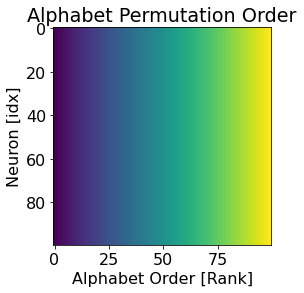

In [80]:
#figure(0) 
clf()
imshow(permutation_key)
ylabel('Neuron [idx]')
xlabel('Alphabet Order [Rank]')
title('Alphabet Permutation Order')

## backup

In [81]:
if toBackup == True:
    timeframe=time.strftime('%Y%m%d%H%M%S')
    filename = 'fig10_%s.png' %(timeframe)
    savefig(filename)
    filename = 'fig10_%s.svg' %(timeframe)
    savefig(filename)

<Figure size 432x288 with 0 Axes>

## 2.40 UPDATE Weights for LPFC/RANK CODE UNITS
## 2.41 RANDOM Weights for LPFC/RANK CODE UNITS

In [82]:
weights_lpfc=randint(num_lpfc,size=(num_lpfc,comp_len))
weights_lpfc_rank=argsort(weights_lpfc,axis=1)
weights_lpfc=modulation[weights_lpfc_rank]

## 2.42 ORDERED Weights for LPFC/RANK CODE UNITS

In [83]:
#weights_lpfc=ones((num_lpfc,comp_len))*modulation
#imshow(weights_lpfc,aspect='auto')

## 2.43 LEARN Weights for LPFC/RANK CODE UNITS

In [84]:
#for idx in arange(num_dlpfc):
    ## input
    #rank_order_idx=argsort(array_mat[idx,:]) # the most active first rank
    #lpfc_activation=dot(weights_lpfc, modulation[rank_order_idx])
    #nn_max=argmax(lpfc_activation)
    #if pos_search_first:
        #weights_lpfc[nn_max,:]=modulation[rank_order_idx]
    #elif rank_search_first:
        #weights_lpfc[nn_max,rank_order_idx]=modulation

## 2.5 LEARN Weights for DLPFC/RANK CODE UNITS

In [87]:
modulation2=zeros(num_lpfc)

for idx in range(num_lpfc): 
    modulation2[idx]=1.0/(idx+1)

In [88]:
weights_dlpfc=randint(num_dlpfc,size=(num_dlpfc,num_lpfc))
weights_dlpfc_rank=argsort(weights_dlpfc,axis=1)
weights_dlpfc=modulation2[weights_dlpfc_rank]

lpfc_activation=zeros(num_lpfc)


In [90]:
for idx in arange(num_dlpfc):
    # input
    seq_len=len(array_mat[idx])
    rank_order_idx=argsort(array_mat[idx,:]) # the most active first rank
    if pos_search_first:
        #lpfc_activation=dot(weights_lpfc, modulation[rank_order_idx])
        #lpfc_activation[::2]=dot(weights_lpfc[::2,rank_order_idx], modulation[::-1])
        for i in arange(num_lpfc):
            input_perm=permutation_key[i,array_mat[idx].astype('int')-1]
            rank_order_idx=argsort(input_perm) # the most active first rank
            lpfc_activation[i]=dot(weights_lpfc[i,:], modulation[rank_order_idx])
    elif rank_search_first:
        #lpfc_activation=dot(weights_lpfc[:,rank_order_idx], modulation)
        #lpfc_activation[::2]=dot(weights_lpfc[::2,rank_order_idx], modulation[::-1])
        for i in arange(num_lpfc):
            input_perm=permutation_key[i,array_mat[idx].astype('int')-1]
            rank_order_idx=argsort(input_perm) # the most active first rank
            lpfc_activation[i]=dot(weights_lpfc[i,rank_order_idx], modulation)
    #rankorder_dlpfc_idx=argsort(lpfc_activation)
    #Kohonen like
    weights_dlpfc[idx,:]=lpfc_activation

## 3 OPTIMIZATION PROCESS

In [91]:
activation_max=1

### 3.1 Select one goal unit

In [92]:
dlpfc_goal=randint(num_dlpfc)

### 3.2 INIT OFC

In [93]:
backed_error=100
lpfc_input=zeros(comp_len)
ofc_output=zeros(comp_len)
ofc_output=randint(amin_val,amax_val+1,comp_len)

num_ofc=num_dlpfc
error_ofc=100*ones(num_ofc) 
weights_ofc=randint(num_ofc,size=(num_dlpfc,comp_len))

error_win=10
output_win=ones(comp_len) 

### 3.3 keep N items orderely within the sequence

In [94]:
num_kept=0
kept_idx=range(num_kept)
ofc_output[kept_idx]=array_mat[dlpfc_goal,kept_idx]

### 3.4 INIT Simulated Annealing

In [96]:
T = 0.0
T_min = 0.00000001
T_min = 0
alpha = 0.999
kb=1.0
d_error=1
dlpfc_threshold=T_min

#3.5 Backup Array
lpfc_dyn=[]
opt_ofc_dyn=[]
dlpfc_dyn=[]
error_dyn=[]

measure1=0
measure2=0

dlpfc_max=dlpfc_goal
iter_search=1000000

### 3.6 Delayed Optimization after X iterations

In [97]:
for iter in range(iter_search):
    # 1 GENERATE NOISE
    if (d_error > 0):
        noise_input=normal(0,0.1,comp_len) 
    # 2 NEW SOLUTION <- ADD NOISE + PREVIOUS SOLUTION
    lpfc_input=noise_input+ofc_output
    # 3 KEEP NORMALIZED
    lpfc_input[where(lpfc_input<amin_val)]=amin_val
    lpfc_input[where(lpfc_input>amax_val)]=amax_val
    # 4 SWAP (TO AVOID LOCAL MINIMA)
    #if (d_error > 0):
    for j in arange(1):
        x=randint(comp_len)
        y=randint(comp_len)
        tmp=lpfc_input[x]
        lpfc_input[x]=lpfc_input[y]
        lpfc_input[y]=tmp
    # 5 KEEP X PERCENT OF TRUE INPUT
    #lpfc_input[kept_idx]=array_mat[dlpfc_goal,kept_idx]
    # 6 RANK ORDER CODE
    rankorder_idx=argsort(lpfc_input)
    # 7 LPFC ACTIVATION 
    if pos_search_first:
        #lpfc_activation=dot(weights_lpfc, modulation[rank_order_idx])
        #lpfc_activation[::2]=dot(weights_lpfc[::2,rank_order_idx], modulation[::-1])
        for i in arange(num_lpfc):
            input_perm=permutation_key[i,lpfc_input.astype('int')-1]
            rank_order_idx=argsort(input_perm) # the most active first rank
            lpfc_activation[i]=dot(weights_lpfc[i,:], modulation[rank_order_idx])
    elif rank_search_first:
        #lpfc_activation=dot(weights_lpfc[:,rank_order_idx], modulation)
        #lpfc_activation[::2]=dot(weights_lpfc[::2,rank_order_idx], modulation[::-1])
        for i in arange(num_lpfc):
            input_perm=permutation_key[i,lpfc_input.astype('int')-1]
            rank_order_idx=argsort(input_perm) # the most active first rank
            lpfc_activation[i]=dot(weights_lpfc[i,rank_order_idx], modulation)
        #lpfc_activation=dot(weights_lpfc[:, rankorder_idx],modulation)
        #lpfc_activation[::2]=dot(weights_lpfc[::2,rank_order_idx], modulation[::-1])
    # 8 dlPFC ACTIVATION 
    # 8.2 Kohonen based
    dlpfc_activation=pow(1+sqrt(mean(pow(weights_dlpfc- lpfc_activation,2),axis=1)),-1)
    # 8.3.1 dlPFC choose ID MAX
    dlpfc_max=argmax(dlpfc_activation)
    # 8.3.2 dlPFC ID GOAL
    #dlpfc_max=dlpfc_goal
    # 9 COMPUTE ERROR
    measure2= mean(pow(activation_max-dlpfc_activation[dlpfc_max],2))
    dlpfc_error=measure2
    # 10 COMPUTE TEMPERATURE
    d_error=dlpfc_error - backed_error
    ap = exp(-d_error/(T*kb))
    print ("iter %d dlpfc %d : %f kept err %f win err %g temp: %f" %( iter, dlpfc_max, dlpfc_error,  backed_error, error_win, T))
    if (dlpfc_error<error_win): # BACKUP BEST SEQUENCE
        error_win=dlpfc_error
        output_win=lpfc_input
        weights_ofc[dlpfc_max,:]=output_win
        dlpfc_win=dlpfc_max
    if (d_error < 0) or (ap > random()): # DESCENT GRADIENT
        backed_error = dlpfc_error        
        ofc_output=lpfc_input
        # BACKUP OFC VECTOR
        error_ofc[dlpfc_max]=dlpfc_error
        weights_ofc[dlpfc_max,:]=ofc_output
        opt_ofc_dyn.append(append(lpfc_input,[dlpfc_max,T, dlpfc_error]))
        error_dyn.append([dlpfc_error,amin(measure2)])
    if T < T_min:
        T=error_win*0.5
        alpha=alpha+0.0001*alpha
    T = T*alpha


<ipython-input-97-4f38bc9049c5>:51: RuntimeWarning: divide by zero encountered in double_scalars
  ap = exp(-d_error/(T*kb))


iter 0 dlpfc 6467 : 0.004346 kept err 100.000000 win err 10 temp: 0.000000
iter 1 dlpfc 6467 : 0.004962 kept err 0.004346 win err 0.00434592 temp: 0.000000
iter 2 dlpfc 6467 : 0.004381 kept err 0.004346 win err 0.00434592 temp: 0.000000
iter 3 dlpfc 1579 : 0.007028 kept err 0.004346 win err 0.00434592 temp: 0.000000
iter 4 dlpfc 1579 : 0.007097 kept err 0.004346 win err 0.00434592 temp: 0.000000
iter 5 dlpfc 6467 : 0.004792 kept err 0.004346 win err 0.00434592 temp: 0.000000
iter 6 dlpfc 6467 : 0.003841 kept err 0.004346 win err 0.00434592 temp: 0.000000
iter 7 dlpfc 6348 : 0.005424 kept err 0.003841 win err 0.00384106 temp: 0.000000
iter 8 dlpfc 6467 : 0.003861 kept err 0.003841 win err 0.00384106 temp: 0.000000
iter 9 dlpfc 1579 : 0.007127 kept err 0.003841 win err 0.00384106 temp: 0.000000
iter 10 dlpfc 5373 : 0.004484 kept err 0.003841 win err 0.00384106 temp: 0.000000
iter 11 dlpfc 6467 : 0.003422 kept err 0.003841 win err 0.00384106 temp: 0.000000
iter 12 dlpfc 1579 : 0.007227 ke

<ipython-input-97-4f38bc9049c5>:51: RuntimeWarning: invalid value encountered in double_scalars
  ap = exp(-d_error/(T*kb))


iter 64 dlpfc 9622 : 0.003961 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 65 dlpfc 6467 : 0.006739 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 66 dlpfc 7944 : 0.007419 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 67 dlpfc 6467 : 0.002209 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 68 dlpfc 12313 : 0.004230 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 69 dlpfc 15779 : 0.004199 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 70 dlpfc 7944 : 0.007402 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 71 dlpfc 6467 : 0.000776 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 72 dlpfc 6467 : 0.000583 kept err 0.000597 win err 0.000596976 temp: 0.000000
iter 73 dlpfc 6467 : 0.000586 kept err 0.000583 win err 0.000582921 temp: 0.000000
iter 74 dlpfc 6467 : 0.000548 kept err 0.000583 win err 0.000582921 temp: 0.000000
iter 75 dlpfc 6467 : 0.000548 kept err 0.000548 win err 0.000547785 temp: 0.000000
it

KeyboardInterrupt: 

In [98]:
opt_ofc_dyn1=array(opt_ofc_dyn)
error_dyn1=array(error_dyn)

In [101]:
len(error_dyn1)

42

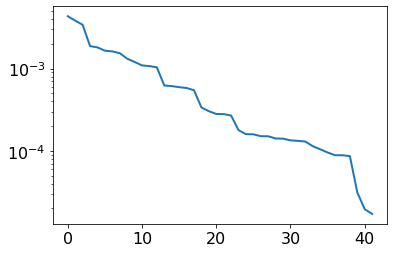

In [102]:
#figure(10) 
clf()
plot(error_dyn1[:,-2],lw=2)
yscale('log')

#### FIG 0 Neural Activity and retrieved sequence

(0.0, 42.0)

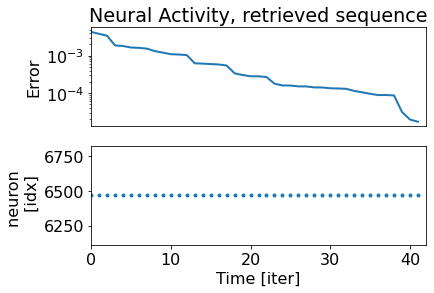

In [103]:
#figure(0) 
clf()
subplot(211)
plot(opt_ofc_dyn1[:,-1],lw=2)
xticks([])
yscale('log')
ylabel('Error')
title('Neural Activity, retrieved sequence')
xlim([0,len(opt_ofc_dyn1)])
subplot(212)
plot(opt_ofc_dyn1[:,-3],'.')
xlabel('Time [iter]')
ylabel('neuron \n [idx]')
xlim([0,len(opt_ofc_dyn1)])

In [105]:
## backup
if toBackup == True:
    timeframe=time.strftime('%Y%m%d%H%M%S')
    filename = 'fig00_%s.png' %(timeframe)
    savefig(filename)
    filename = 'fig00_%s.svg' %(timeframe)
    savefig(filename)

<Figure size 432x288 with 0 Axes>

#### FIG 1 Neural Activity and retrieved sequence

Text(0, 0.5, 'retrieved sequence \n [idx/pos]')

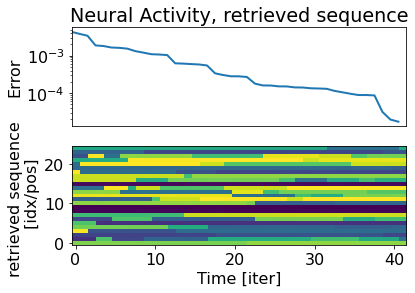

In [106]:
#figure(1) 
clf()
subplot(211)
plot(opt_ofc_dyn1[:,-1],lw=2)
xticks([])
yscale('log')
ylabel('Error')
title('Neural Activity, retrieved sequence')
xlim([0,len(opt_ofc_dyn1)])

subplot(212)
imshow(opt_ofc_dyn1[:,:comp_len].T, origin='lower', aspect='auto',interpolation='none')
xlabel('Time [iter]')
ylabel('retrieved sequence \n [idx/pos]')

In [107]:
## backup
if toBackup == True:
    timeframe=time.strftime('%Y%m%d%H%M%S')
    filename = 'fig01_%s.png' %(timeframe)
    savefig(filename)
    filename = 'fig01_%s.svg' %(timeframe)
    savefig(filename)

<Figure size 432x288 with 0 Axes>

#### FIGURE 2 RETRIEVED SEQUENCE & RANK

Text(0.5, 0, 'position')

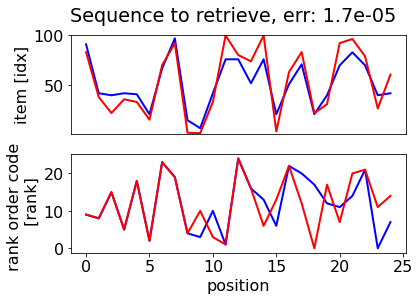

In [109]:
iter=argmin(opt_ofc_dyn1[:,-1])
iter=-1
dlpfc_max=int(opt_ofc_dyn1[iter,-3])
retrieved_seq=opt_ofc_dyn1[iter,:-3]
#seq_retrieved_norm=retrieved_seq
#retrieved_seq=weights_ofc[dlpfc_max,:]
#seq_retrieved_norm=renormalize(retrieved_seq,amin_val,amax_val)
#rank_select= int(error_dyn1[-1,-3])

#figure(2)
clf()
#suptitle('Sequence to retrieve, err: %.2f' %opt_ofc_dyn1[-1,-1])
#suptitle('Sequence to retrieve, err: %.2g' %error_win)
suptitle('Sequence to retrieve, err: %.2g' %error_dyn1[iter,-2])

subplot(211)
plot(array_mat[dlpfc_max,:],'b',lw=2)
#plot(array_mat[dlpfc_goal,:],'b',lw=2)
#plot(array_mat[dlpfc_win,:],'b',lw=2)
#plot(output_win,'r',lw=2)
#plot(renormalize(output_win,1,102),'r',lw=2)
#plot(seq_retrieved_norm,'r',lw=2)
plot(retrieved_seq,'r',lw=2)
ylabel('item [idx]')
xticks([])
ylim([amin_val,amax_val])

subplot(212)
plot(argsort(array_mat[dlpfc_max,:]),'b',lw=2)
#plot(argsort(array_mat[dlpfc_goal,:]),'b',lw=2)
#plot(argsort(array_mat[dlpfc_win,:]),'b',lw=2)
#plot(argsort(output_win),'r',lw=2)
plot(argsort(retrieved_seq),'r',lw=2)
ylabel('rank order code \n [rank]')
xlabel('position')

In [110]:
## backup) 
if toBackup == True:
    timeframe=time.strftime('%Y%m%d%H%M%S')
    filename = 'fig02_%s.png' %(timeframe)
    savefig(filename)
    filename = 'fig02_%s.svg' %(timeframe)
    savefig(filename)

<Figure size 432x288 with 0 Axes>

In [111]:
sentence_retrieved=[]
sentence_goal=[]

for i in range(num_len1):
    for j in range(102):
        if(j==(retrieved_seq[i].astype(int))) :
            sentence_retrieved.append(text2int[j][0])
        if(j==(array_mat[dlpfc_max,i]).astype(int)) :
            sentence_goal.append(text2int[j][0])

sentence_retrieved
sentence_goal

retrieved_seq_bak1=retrieved_seq
dlpfc_max1=dlpfc_max

#### FIGURE 3 ANIMATION of FIGURE 2, RETRIEVED SEQUENCE

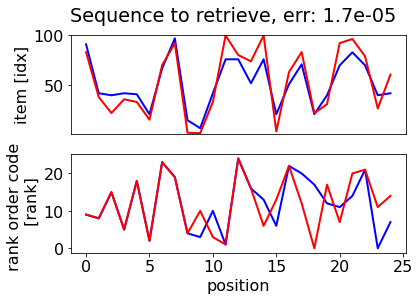

In [112]:
len_seq=len(opt_ofc_dyn1)
step_seq=1
timeframe=time.strftime('%Y%m%d%H%M%S')

#figure(3)
clf()

for iter in arange(len_seq, step=step_seq):
    dlpfc_max=int(opt_ofc_dyn1[iter,-3])
    retrieved_seq=opt_ofc_dyn1[iter,:-3]
    clf()
    suptitle('Sequence to retrieve, err: %.2g' %opt_ofc_dyn1[iter,-1])
    subplot(211)
    plot(array_mat[dlpfc_max,:],'b',lw=2)
    plot(retrieved_seq,'r',lw=2)
    ylabel('item [idx]')
    xticks([])
    ylim([amin_val,amax_val])
    subplot(212)
    plot(argsort(array_mat[dlpfc_max,:]),'b',lw=2)
    plot(argsort(retrieved_seq),'r',lw=2)
    ylabel('rank order code \n [rank]')
    xlabel('position')
    if toBackup == True:
        filename = 'fig03_%s_%.6d.png' %(timeframe,iter)
        savefig(filename)